# Model Testing and Predictions on Smaller images

# VGG19 trained on AOI


# 1. Set up

In [1]:
 from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5128704175688598226
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16340214315456316363
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [3]:
!pip install tensorflow-addons --quiet

     |████████████████████████████████| 1.1 MB 4.3 MB/s 


In [4]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications.vgg19 import preprocess_input
import tensorflow_addons as tfa
import os
import tempfile


from keras.utils.vis_utils import plot_model

import sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

In [5]:
# Define paths:
pathtoCSV = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/CSV_Files/'
pathtoImages = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Images/'
pathtoSave = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Saved_models/VGG19/'
pathtoResults = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Models_performance/VGG19/EQ/'

#2. Input Pipeline

In [ ]:
def read_labels( pathtoCSV ):
  labels_csv = pd.read_csv(pathtoCSV + 'Train_Val_Reshuffle_SINGLE.csv',dtype=str)
  labels_csv['Class'] = labels_csv['Class'].astype(int)
  classes_zero = labels_csv[labels_csv['Class'] == 0]
  classes_one = labels_csv[labels_csv['Class'] == 1]
  bal = abs(int(len(classes_one) - len(classes_zero)))
  labels_csv.drop((labels_csv.query('Class== 0').sample(n=bal).index),inplace = True)
  return labels_csv

labels_csv = read_labels(pathtoCSV)

In [ ]:
def image_generator(pathtoImages ):
  train_datagen = ImageDataGenerator(
      preprocessing_function = preprocess_input,
  )
  val_datagen = ImageDataGenerator(
      preprocessing_function = preprocess_input,
  )
  labels_csv['Class'] = labels_csv['Class'].astype(str)
  labels_csv['File_name'] = labels_csv['File_Name'].astype(str)


  train_generator = train_datagen.flow_from_dataframe(
      labels_csv,
      directory = pathtoImages + 'Train',
      x_col = 'File_Name',
      y_col = 'Class',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=True,
      seed= 1,
      class_mode = 'binary',
      batch_size = 16
  )

  val_generator = val_datagen.flow_from_dataframe(
      labels_csv,
      directory = pathtoImages + 'Validation',
      x_col = 'File_Name',
      y_col = 'Class',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=True,
      seed= 1,
      class_mode = 'binary',
      batch_size = 16
  )
  return train_generator, val_generator


train_generator, val_generator = image_generator(pathtoImages)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 466 invalid image filename(s) in x_col="File_Name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 1668 validated image filenames belonging to 2 classes.
Found 466 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1668 invalid image filename(s) in x_col="File_Name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


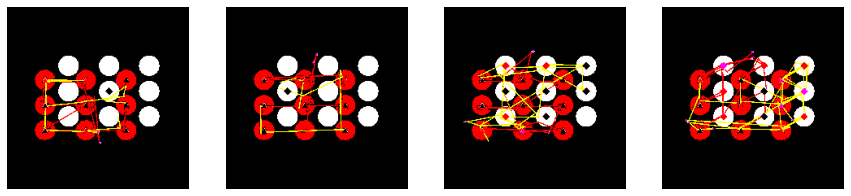

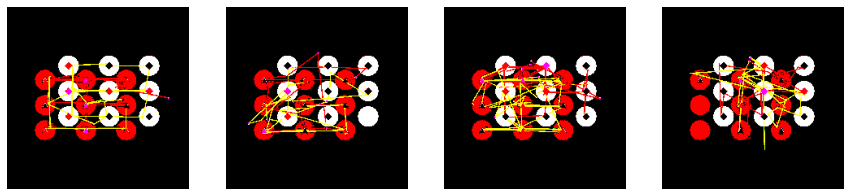

In [ ]:
# plotting train images
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):
  # convert to unsigned integers for plotting
  image = next(train_generator)[0][i].astype('float')
  # plot raw pixel data
  ax[i].imshow(image)
  ax[i].axis('off')

# plotting val images
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):

  # convert to unsigned integers for plotting
  image = next(val_generator)[0][i].astype('float')
  # plot raw pixel data
  ax[i].imshow(image)
  ax[i].axis('off')

#3. Build and train best model selected with Bayesian Tuner

Best model retrieved by Bayesian tuner:\
units: 1024\
dropout: 0.5000000000000001\
Score: 0.731182813644409

In [ ]:
# Define early-stopping:
early_stopping_1 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=4, 
    mode='auto',
    restore_best_weights=True)

In [ ]:
# Define Metrics:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      tfa.metrics.F1Score(num_classes = 1, average = 'micro', threshold = 0.5),
]

In [ ]:
# Original code source for regularizer: https://sthalles.github.io/keras-regularizer/

def build_model():
  base_model = VGG19(weights='imagenet', include_top=False)
  for layers in base_model.layers:
    layers.trainable=False
  x= base_model.output
  x= GlobalAveragePooling2D()(x)
  x= Dense(1024,activation='relu')(x)
  x=Dropout(0.5000000000000001)(x)
  output=Dense(1,activation='sigmoid')(x)
  model=Model(inputs=base_model.input,outputs=output)
  regularizer=tf.keras.regularizers.L1L2(1e-5)
  if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
    print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
    return model

  for layer in model.layers:
    for attr in ['kernel_regularizer']:
      if hasattr(layer, attr):
        setattr(layer, attr, regularizer)

  # When we change the layers attributes, the change only happens in the model config file
  model_json = model.to_json()

  # Save the weights before reloading the model.
  tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
  model.save_weights(tmp_weights_path)

  # load the model from the config
  model = tf.keras.models.model_from_json(model_json)
    
  # Reload the model weights
  model.load_weights(tmp_weights_path, by_name=True)
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(1e-5, decay_steps=100000, decay_rate=0.75, staircase=True)
  opt = SGD(learning_rate = lr_schedule, momentum=0.99) 
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics= METRICS)
  return model

model = build_model()

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
history = model.fit(
    train_generator,
    batch_size = 16,
    epochs = 30,
    callbacks= early_stopping_1,
    validation_data = val_generator,
    shuffle = True
)

Epoch 1/30
105/105 [==============================] - 829s 8s/step - loss: 2.7649 - tp: 462.0000 - fp: 392.0000 - tn: 440.0000 - fn: 374.0000 - accuracy: 0.5408 - precision: 0.5410 - recall: 0.5526 - auc: 0.5524 - f1_score: 0.5467 - val_loss: 2.0809 - val_tp: 91.0000 - val_fp: 36.0000 - val_tn: 199.0000 - val_fn: 140.0000 - val_accuracy: 0.6223 - val_precision: 0.7165 - val_recall: 0.3939 - val_auc: 0.7622 - val_f1_score: 0.5084
Epoch 2/30
105/105 [==============================] - 90s 861ms/step - loss: 2.4390 - tp: 510.0000 - fp: 317.0000 - tn: 515.0000 - fn: 326.0000 - accuracy: 0.6145 - precision: 0.6167 - recall: 0.6100 - auc: 0.6530 - f1_score: 0.6133 - val_loss: 2.0595 - val_tp: 195.0000 - val_fp: 98.0000 - val_tn: 137.0000 - val_fn: 36.0000 - val_accuracy: 0.7124 - val_precision: 0.6655 - val_recall: 0.8442 - val_auc: 0.7803 - val_f1_score: 0.7443
Epoch 3/30
105/105 [==============================] - 89s 849ms/step - loss: 2.2612 - tp: 551.0000 - fp: 302.0000 - tn: 530.0000 - f

In [ ]:
def plot_metrics(history, name_file):
  '''
  Funcitons to plot metrics ('accuracy', 'tp', 'fp', 'loss', 'tn', 'fn',  'precision', 'recall', 'auc') in subplots.
  Adjust the figsize for overlal size of plot
  Adjust fontsize for labels
  Adjust linewidth for line of graphs

  Args:
   History - tensorflow object
  
  Returns:
  '''
  metrics = ['accuracy', 'tp', 'fp', 'loss', 'tn', 'fn',  'precision', 'recall', 'auc', 'f1_score']
  fig, ax = plt.subplots(4,3, figsize=(30,20))
  fig.suptitle('Model Metric Plots',fontsize=40)
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(4,3,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train', linewidth=3)
    plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val', linewidth=3)
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel(name, fontsize=10)
    plt.title(str(name))
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])

    plt.legend(fontsize=10)
    plt.savefig(pathtoResults + name_file)

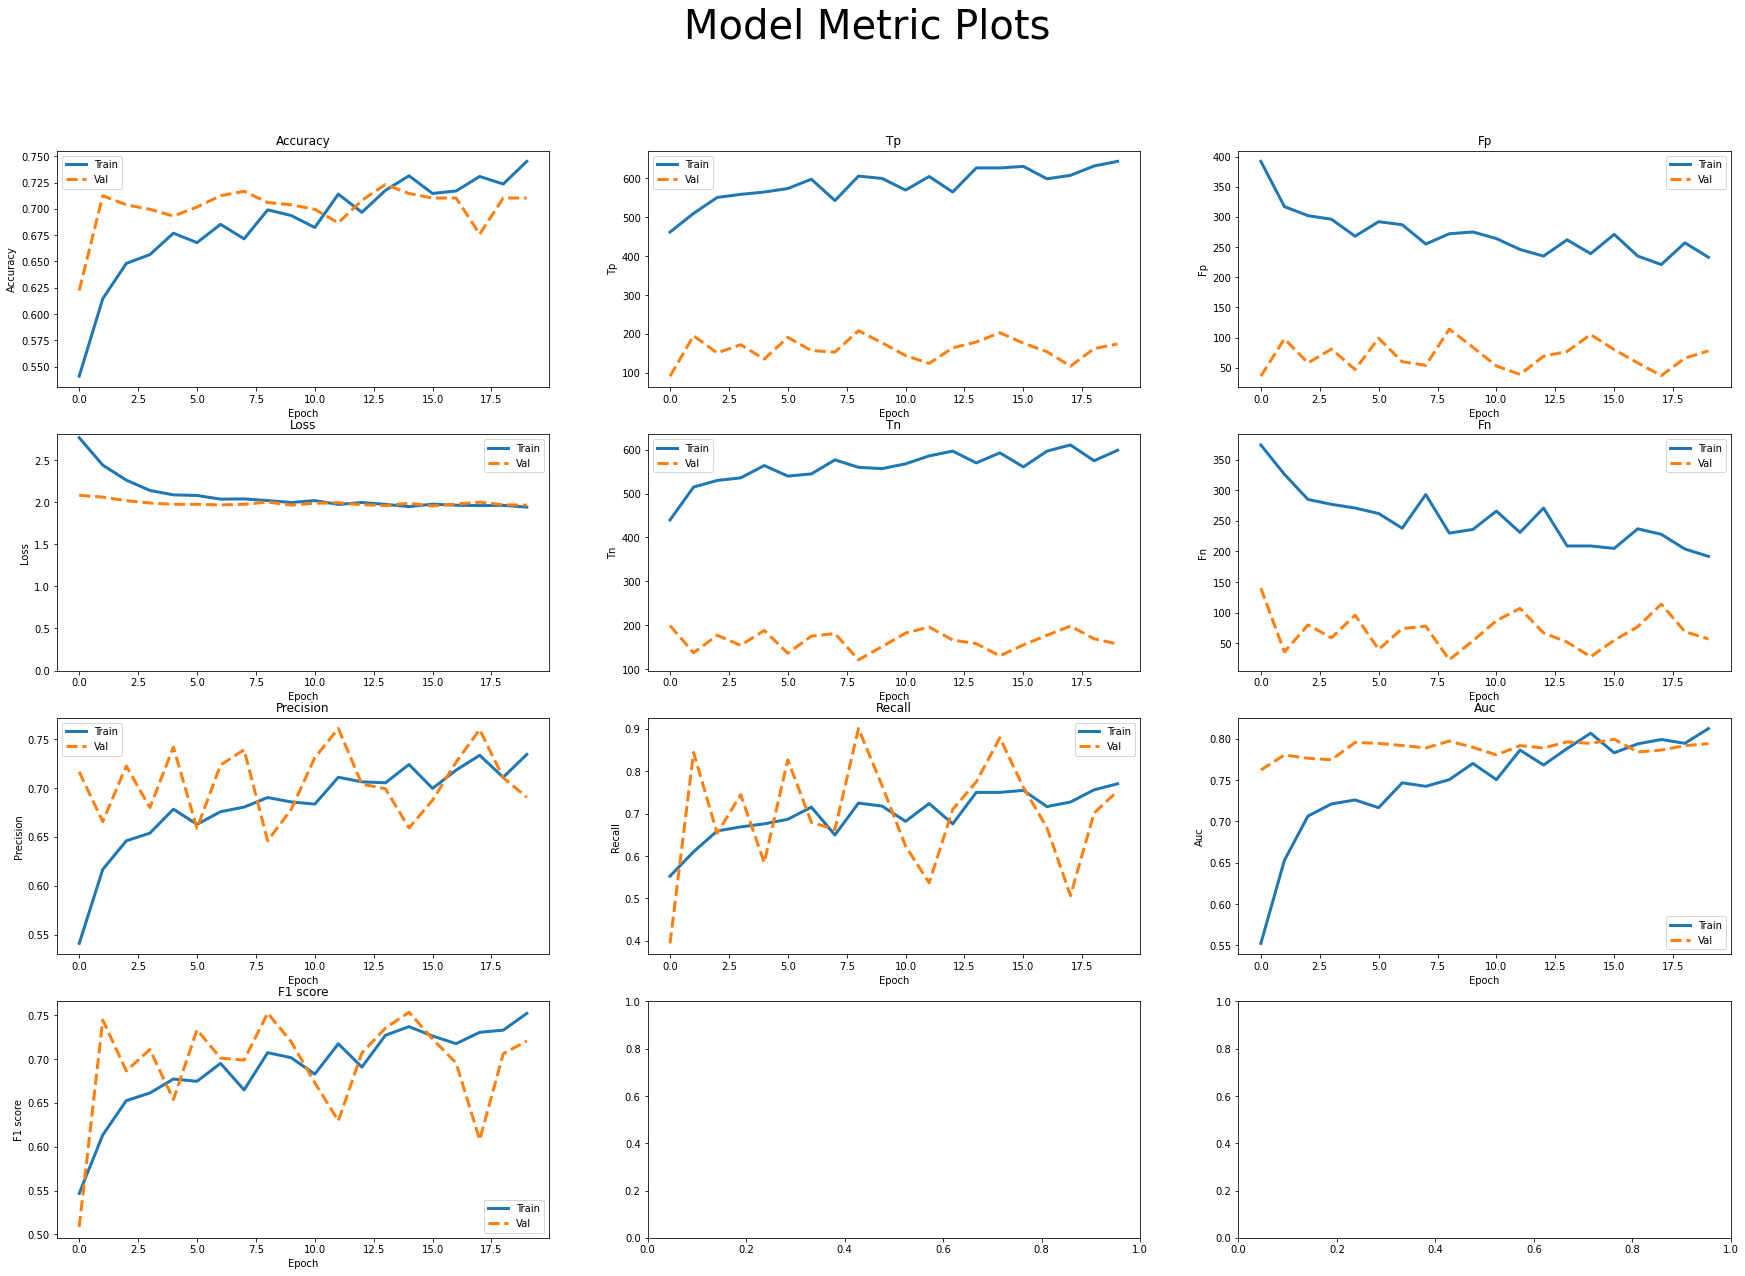

In [ ]:
plot_metrics(history= history, name_file ='history_val.png')

In [ ]:
#convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history)
frames = [hist_df]
result = pd.concat(frames)
# or save to csv: 
hist_csv_file = pathtoResults + 'history_val.csv'
with open(hist_csv_file, mode='w') as f:
    result.to_csv(f)

#4. Fine tune model with best tuning identified by Randomsearch

Trial summary\
Hyperparameters:\
num_frozen_layers: 7\
learning_rate: 1e-06

In [ ]:
# Define early-stopping:
early_stopping_2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=3, 
    mode='auto',
    restore_best_weights=True)

In [ ]:
# reset the train and validation generators:
train_generator.reset()
val_generator.reset()

In [ ]:
for layer in model.layers[7:]:
	layer.trainable = True

In [ ]:
lr_sched = tf.keras.optimizers.schedules.ExponentialDecay(1e-6, decay_steps=100000, decay_rate=0.75, staircase=True)
opt_2 = SGD(learning_rate = lr_sched, momentum=0.99) 
model.compile(optimizer=opt_2, loss='binary_crossentropy', metrics= METRICS)

In [ ]:
history_2 = model.fit(
    train_generator,
    batch_size = 16,
    epochs = 10,
    callbacks= early_stopping_2,
    validation_data = val_generator,
    shuffle = True
)

Epoch 1/10
105/105 [==============================] - 100s 917ms/step - loss: 1.9474 - tp: 819.0000 - fp: 317.0000 - tn: 750.0000 - fn: 248.0000 - accuracy: 0.7352 - precision: 0.7210 - recall: 0.7676 - auc: 0.8046 - f1_score: 0.7435 - val_loss: 1.9565 - val_tp: 169.0000 - val_fp: 64.0000 - val_tn: 171.0000 - val_fn: 62.0000 - val_accuracy: 0.7296 - val_precision: 0.7253 - val_recall: 0.7316 - val_auc: 0.7976 - val_f1_score: 0.7284
Epoch 2/10
105/105 [==============================] - 93s 887ms/step - loss: 1.9417 - tp: 640.0000 - fp: 254.0000 - tn: 578.0000 - fn: 196.0000 - accuracy: 0.7302 - precision: 0.7159 - recall: 0.7656 - auc: 0.8113 - f1_score: 0.7399 - val_loss: 1.9480 - val_tp: 179.0000 - val_fp: 77.0000 - val_tn: 158.0000 - val_fn: 52.0000 - val_accuracy: 0.7232 - val_precision: 0.6992 - val_recall: 0.7749 - val_auc: 0.8056 - val_f1_score: 0.7351
Epoch 3/10
105/105 [==============================] - 92s 880ms/step - loss: 1.9536 - tp: 620.0000 - fp: 248.0000 - tn: 584.0000 

In [ ]:
!mkdir -p saved_models_and_weights
model.save(filepath = pathtoSave + 'VGG_19_EQ_best_model')

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Saved_models/VGG19/VGG_19_EQ_best_model/assets


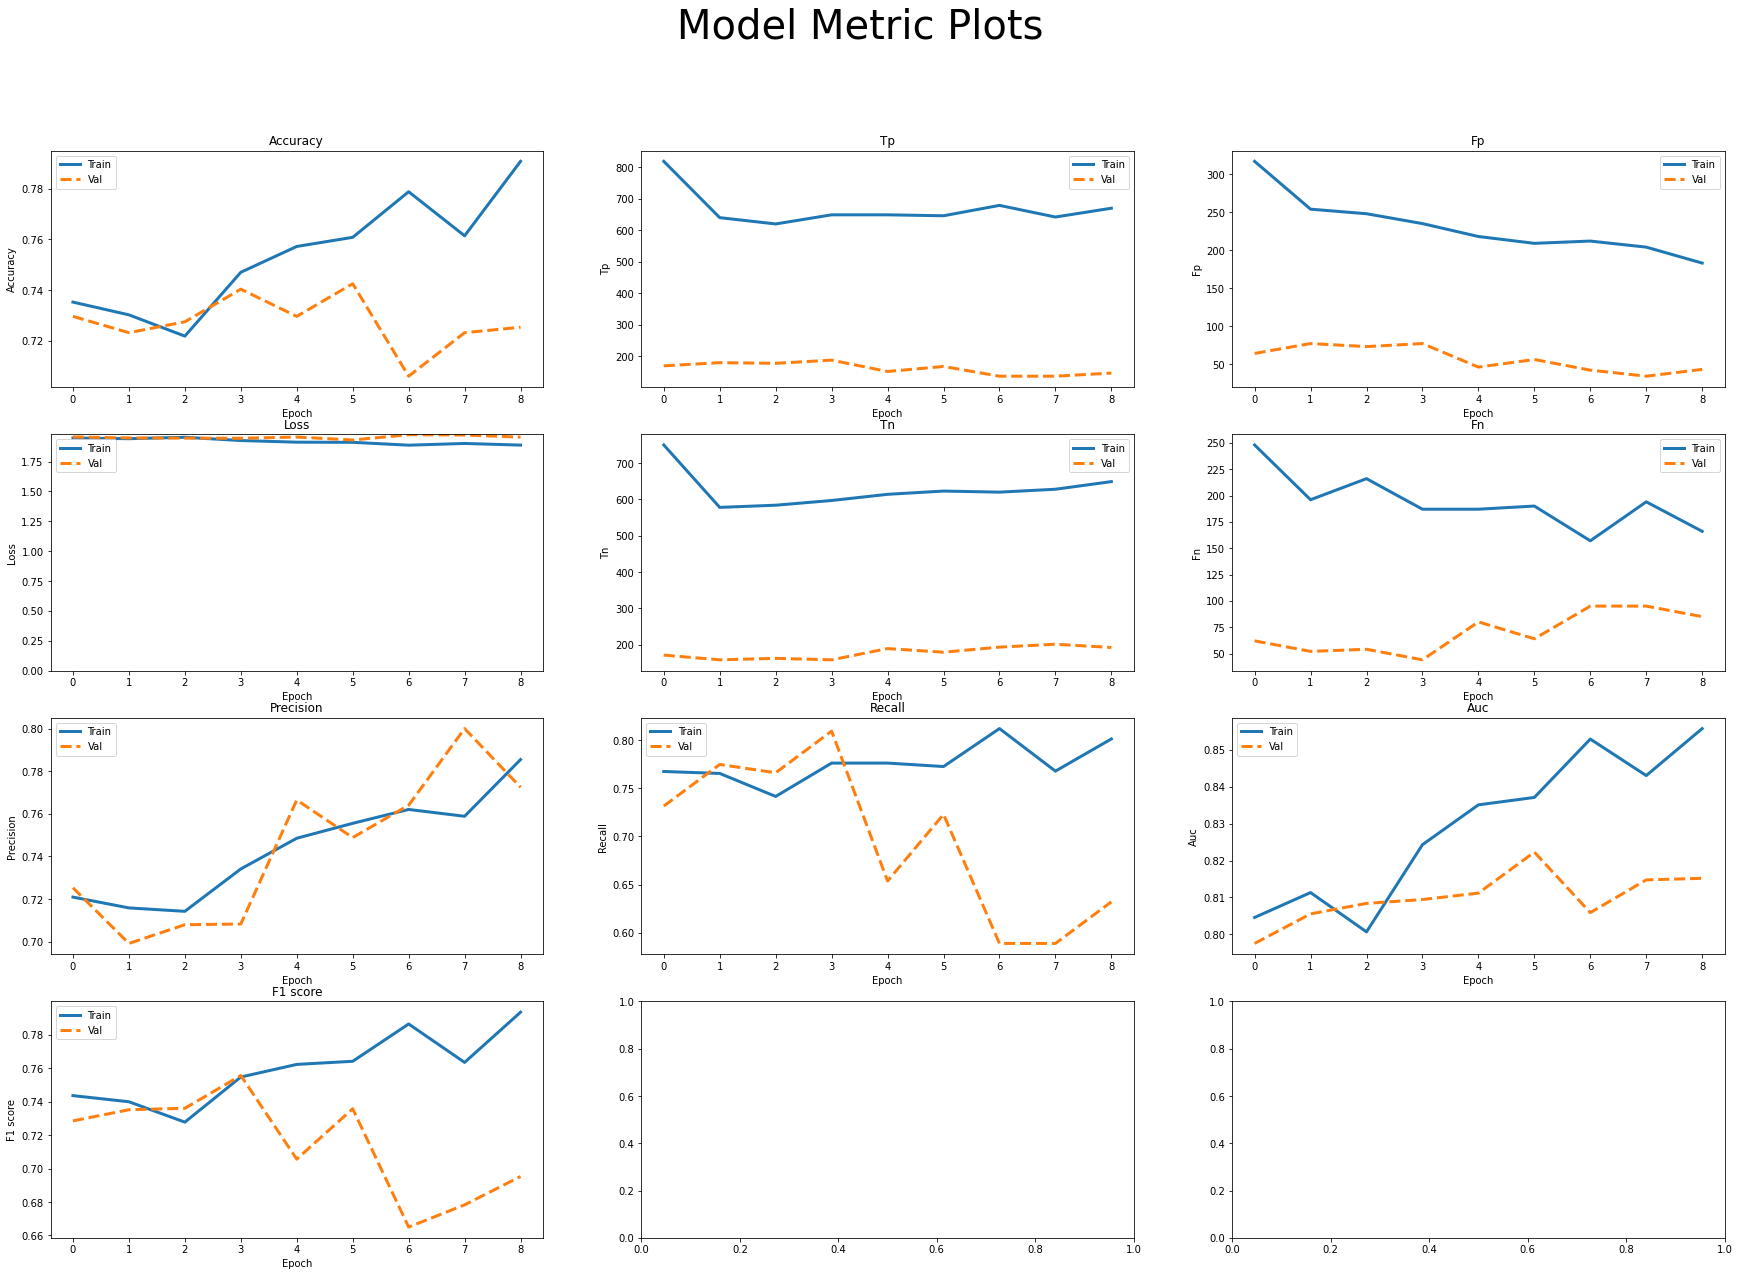

In [ ]:
plot_metrics(history=history_2, name_file = 'history_best_model_val.png')

In [ ]:
#convert the history.history dict to a pandas DataFrame:     
hist_df_2 = pd.DataFrame(history_2.history)
frames = [hist_df_2]
result = pd.concat(frames)
# or save to csv: 
hist_csv_file = pathtoResults + 'history_best_model_val.csv'
with open(hist_csv_file, mode='w') as f:
    result.to_csv(f)

# Test Generators

In [ ]:
# load test data:
labels_xl = pd.read_csv(pathtoCSV + 'Test_Reshuffle.csv',dtype=str)

# Paths to test images:
test_percentage = 'test_percentages/'
test_timing = 'test_timings/'

In [ ]:
def load_test_images(test_full, test_80, test_50, test_30, test_15, test_15s, test_10s, test_5s, test_2s):
  test_datagen = ImageDataGenerator(
      preprocessing_function = preprocess_input,
  )
  labels_xl['Class'] = labels_xl['Class'].astype(str)
  labels_xl['File_Name'] = labels_xl['File_Name'].astype(str)

  test_generator_full_images = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_full,
      x_col = 'File_Name',
      y_col = 'Class',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'binary',
      batch_size = 16
  )
  test_generator_80_percent = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_80,
      x_col = 'File_Name',
      y_col = 'Class',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'binary',
      batch_size = 16
  )
  test_generator_50_percent = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_50,
      x_col = 'File_Name',
      y_col = 'Class',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'binary',
      batch_size = 16
  )
  test_generator_30_percent = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_30,
      x_col = 'File_Name',
      y_col = 'Class',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'binary',
      batch_size = 16
  )
  test_generator_15_percent = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_15,
      x_col = 'File_Name',
      y_col = 'Class',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'binary',
      batch_size = 16
  )
  test_generator_15_secs = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_15s,
      x_col = 'File_Name',
      y_col = 'Class',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'binary',
      batch_size = 16
  )
  test_generator_10_secs = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_10s,
      x_col = 'File_Name',
      y_col = 'Class',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'binary',
      batch_size = 16
  )
  test_generator_5_secs = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_5s,
      x_col = 'File_Name',
      y_col = 'Class',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'binary',
      batch_size = 16
  )
  test_generator_2_secs = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_2s,
      x_col = 'File_Name',
      y_col = 'Class',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'binary',
      batch_size = 16
  )

  return test_generator_full_images, test_generator_80_percent, test_generator_50_percent, test_generator_30_percent, test_generator_15_percent, test_generator_15_secs, test_generator_10_secs, test_generator_5_secs, test_generator_2_secs

In [ ]:
# Load all images
test_full = pathtoImages + 'Test/'
test_80 = pathtoImages + test_percentage + 'Test_80/'
test_50 = pathtoImages + test_percentage + 'Test_50/'
test_30 = pathtoImages + test_percentage + 'Test_30/'
test_15 = pathtoImages + test_percentage + 'Test_15/'
test_15s = pathtoImages + test_timing + 'Test_15s/'
test_10s = pathtoImages + test_timing + 'Test_10s/'
test_5s = pathtoImages + test_timing + 'Test_5s/'
test_2s = pathtoImages + test_timing + 'Test_2s/'
test_generator_full_images, test_generator_80_percent, test_generator_50_percent,  test_generator_30_percent, test_generator_15_percent, test_generator_15_secs, test_generator_10_secs, test_generator_5_secs, test_generator_2_secs = load_test_images(test_full, test_80, test_50, test_30, test_15, test_15s, test_10s, test_5s, test_2s)

Found 250 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.


#Eval

In [ ]:
evaluation_full = model.evaluate(test_generator_full_images)
evaluation_80 = model.evaluate(test_generator_80_percent)
evaluation_50 = model.evaluate(test_generator_50_percent)
evaluation_30 = model.evaluate(test_generator_30_percent)
evaluation_15 = model.evaluate(test_generator_15_percent)

16/16 [==============================] - 84s 6s/step - loss: 2.1254 - tp: 26.0000 - fp: 39.0000 - tn: 105.0000 - fn: 80.0000 - accuracy: 0.5240 - precision: 0.4000 - recall: 0.2453 - auc: 0.4978 - f1_score: 0.3041


In [ ]:
evaluation_15s = model.evaluate(test_generator_15_secs)
evaluation_10s = model.evaluate(test_generator_10_secs)
evaluation_5s = model.evaluate(test_generator_5_secs)
evaluation_2s = model.evaluate(test_generator_2_secs)

16/16 [==============================] - 81s 5s/step - loss: 2.0710 - tp: 25.0000 - fp: 17.0000 - tn: 127.0000 - fn: 81.0000 - accuracy: 0.6080 - precision: 0.5952 - recall: 0.2358 - auc: 0.6245 - f1_score: 0.3378


In [ ]:
eval_percentage = {'dataset':  ['full', '80', '50', '30', '15'],
        'loss': [evaluation_full[0], evaluation_80[0], evaluation_50[0], evaluation_30[0], evaluation_15[0]],
        'tp': [evaluation_full[1], evaluation_80[1], evaluation_50[1], evaluation_30[1], evaluation_15[1]],
        'fp': [evaluation_full[2], evaluation_80[2], evaluation_50[2], evaluation_30[2], evaluation_15[2]],
        'tn': [evaluation_full[3], evaluation_80[3], evaluation_50[3], evaluation_30[3], evaluation_15[3]],
        'fn': [evaluation_full[4], evaluation_80[4], evaluation_50[4], evaluation_30[4], evaluation_15[4]],
        'accuracy': [evaluation_full[5], evaluation_80[5], evaluation_50[5], evaluation_30[5], evaluation_15[5]],
        'precision': [evaluation_full[6], evaluation_80[6], evaluation_50[6], evaluation_30[6], evaluation_15[6]],
        'recall': [evaluation_full[7], evaluation_80[7], evaluation_50[7], evaluation_30[7], evaluation_15[7]],
        'auc': [evaluation_full[8], evaluation_80[8], evaluation_50[8], evaluation_30[8], evaluation_15[8]],
        'f1_score': [evaluation_full[9], evaluation_80[9], evaluation_50[9], evaluation_30[9], evaluation_15[9]],
        }

eval_results_percentage = pd.DataFrame(eval_percentage)

In [ ]:
percentage_csv_results = eval_results_percentage.to_csv(pathtoResults + 'eval_results_percentage.csv', index= True)

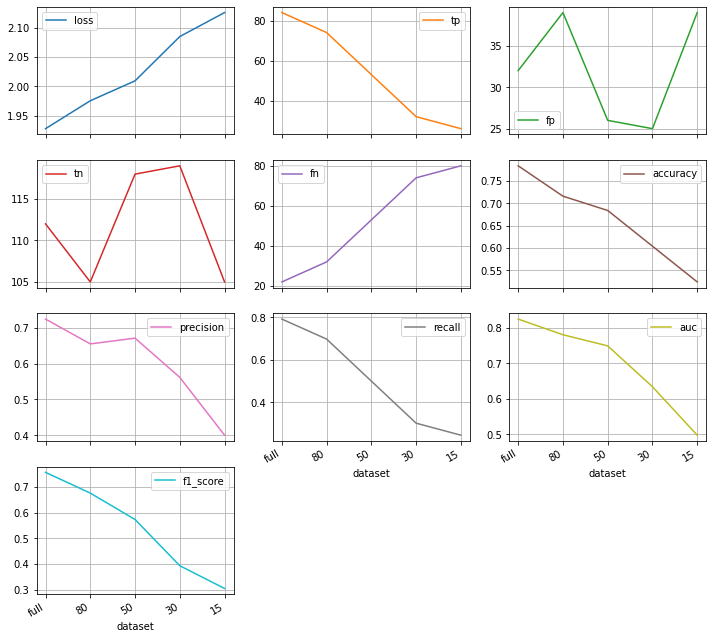

In [ ]:
eval_results_percentage.plot(x= 'dataset', grid=True, subplots=True, layout=(4, 3), figsize = (12,12))
plt.savefig(pathtoResults + 'eval_percentage_results_figures.png')

In [ ]:
eval_timing = {'dataset':  ['full', '15s', '10s', '5s', '2s'],
        'loss': [evaluation_full[0], evaluation_15s[0], evaluation_10s[0], evaluation_5s[0], evaluation_2s[0]],
        'tp': [evaluation_full[1], evaluation_15s[1], evaluation_10s[1], evaluation_5s[1], evaluation_2s[1]],
        'fp': [evaluation_full[2], evaluation_15s[2], evaluation_10s[2], evaluation_5s[2], evaluation_2s[2]],
        'tn': [evaluation_full[3], evaluation_15s[3], evaluation_10s[3], evaluation_5s[3], evaluation_2s[3]],
        'fn': [evaluation_full[4], evaluation_15s[4], evaluation_10s[4], evaluation_5s[4], evaluation_2s[4]],
        'accuracy': [evaluation_full[5], evaluation_15s[5], evaluation_10s[5], evaluation_5s[5], evaluation_2s[5]],
        'precision': [evaluation_full[6], evaluation_15s[6], evaluation_10s[6], evaluation_5s[6], evaluation_2s[6]],
        'recall': [evaluation_full[7], evaluation_15s[7], evaluation_10s[7], evaluation_5s[7], evaluation_2s[7]],
        'auc': [evaluation_full[8], evaluation_15s[8], evaluation_10s[8], evaluation_5s[8], evaluation_2s[8]],
        'f1_score': [evaluation_full[9], evaluation_15s[9], evaluation_10s[9], evaluation_5s[9], evaluation_2s[9]],
        }

eval_results_timing = pd.DataFrame(eval_timing)

In [ ]:
timing_csv_results = eval_results_timing.to_csv(pathtoResults + 'eval_results_timing.csv', index= True)

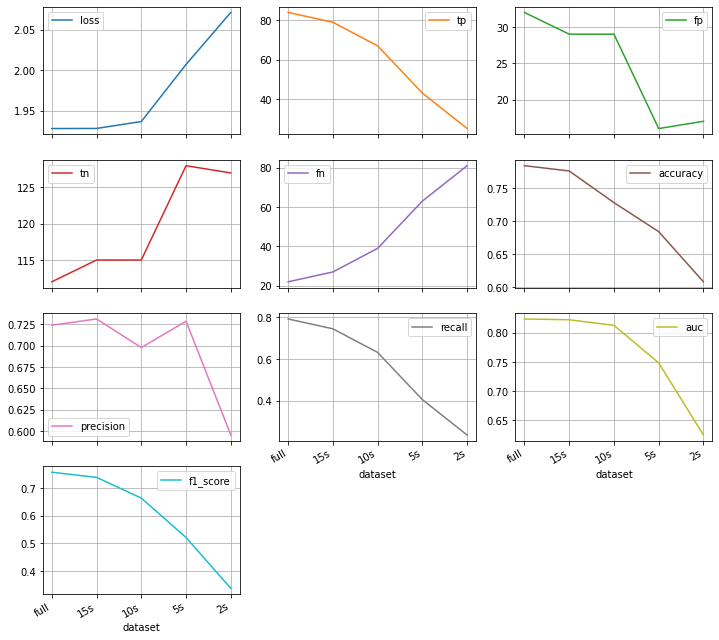

In [ ]:
eval_results_timing.plot(x= 'dataset', grid=True, subplots=True, layout=(4, 3), figsize = (12,12))
plt.savefig(pathtoResults + 'eval_timing_results_figures.png')

# Save results as unique plot

In [12]:
data1 = {'dataset':  ['val','full', '15s', '10s', '5s', '2s'],
        'loss': [hist_df_2.iloc[5,11],evaluation_full[0], evaluation_15s[0], evaluation_10s[0], evaluation_5s[0], evaluation_2s[0]],
        'accuracy': [hist_df_2.iloc[5,16], evaluation_full[5], evaluation_15s[5], evaluation_10s[5], evaluation_5s[5], evaluation_2s[5]],
        'precision': [hist_df_2.iloc[5,17], evaluation_full[6], evaluation_15s[6], evaluation_10s[6], evaluation_5s[6], evaluation_2s[6]],
        'recall': [hist_df_2.iloc[5,18], evaluation_full[7], evaluation_15s[7], evaluation_10s[7], evaluation_5s[7], evaluation_2s[7]],
        'auc': [hist_df_2.iloc[5,19], evaluation_full[8], evaluation_15s[8], evaluation_10s[8], evaluation_5s[8], evaluation_2s[8]],
        'f1': [hist_df_2.iloc[5,20], evaluation_full[9], evaluation_15s[9], evaluation_10s[9], evaluation_5s[9], evaluation_2s[9]],
        }
data1 = pd.DataFrame(data1)
data1.to_csv(pathtoResults + 'results_EQ_timings.csv', index= True)
data2 = {'dataset':  ['val', 'full', '80', '50', '30', '15'],
        'loss': [hist_df_2.iloc[5,11],evaluation_full[0], evaluation_80[0], evaluation_50[0], evaluation_30[0], evaluation_15[0]],
        'accuracy': [hist_df_2.iloc[5,16], evaluation_full[5], evaluation_80[5], evaluation_50[5], evaluation_30[5], evaluation_15[5]],
        'precision': [hist_df_2.iloc[5,17],evaluation_full[6], evaluation_80[6], evaluation_50[6], evaluation_30[6], evaluation_15[6]],
        'recall': [hist_df_2.iloc[5,18],evaluation_full[7], evaluation_80[7], evaluation_50[7], evaluation_30[7], evaluation_15[7]],
        'auc': [hist_df_2.iloc[5,19],evaluation_full[8], evaluation_80[8], evaluation_50[8], evaluation_30[8], evaluation_15[8]],
        'f1': [hist_df_2.iloc[5,20],evaluation_full[9], evaluation_80[9], evaluation_50[9], evaluation_30[9], evaluation_15[9]],
        }

data2 = pd.DataFrame(data2)
data2.to_csv(pathtoResults + 'results_EQ_percentages.csv', index= True)

In [10]:
def plot_all_results(data1, data2, name_file):
  metrics = ['loss_timings', 'loss_percentage', 'accuracy_timings', 'accuracy_percentages', 'precision_timings', 'precision_percentages','recall_timings', 'recall_percentages','auc_timings', 'auc_percentages', 'f1_timings', 'f1_percentages']
  fig, ax = plt.subplots(3,4, figsize=(30,20))
  fig.suptitle('VGG19 Model in binary classification task Metric Plots',fontsize=40)
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    mtc = metric.split("_", 1)[0]
    plt.subplot(3,4,n+1)
    if n ==0:
      plt.plot(data1.iloc[:,0], data1[mtc], linewidth=3)
    elif n % 2 == 0:
      plt.plot(data1.iloc[:,0], data1[mtc], linewidth=3)
    else:
      plt.plot(data2.iloc[:,0], data2[mtc], linewidth=3)
    plt.xlabel('Dataset', fontsize=10)
    plt.title(str(name))
    plt.savefig(pathtoResults + name_file)

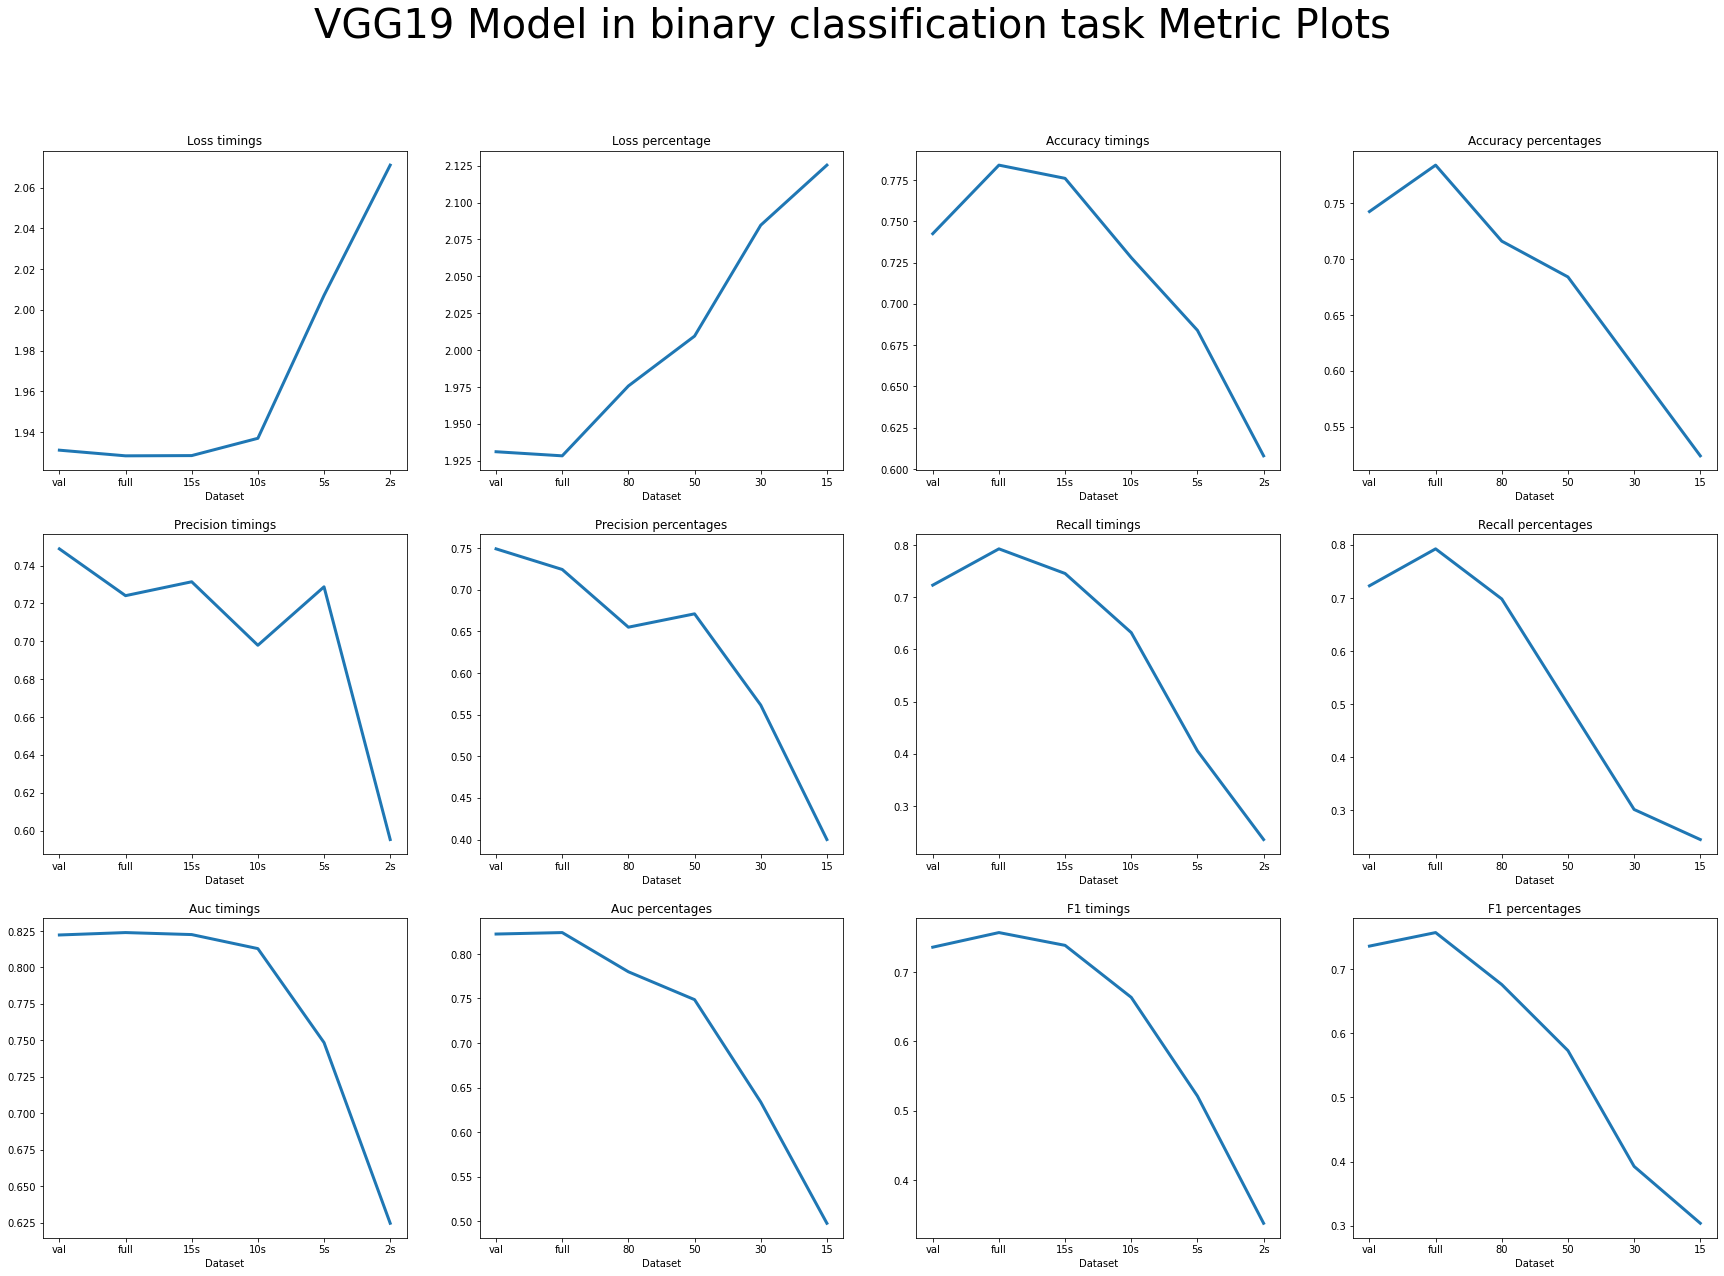

In [11]:
plot_all_results(data1, data2, "results_VGG_EQ.png")